In [1]:
# Import module
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets

from copy import deepcopy
from itertools import product
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from train_tools import TrainHelper
from model_task2c import PR_CNN

In [2]:
# load data
TRAIN_DATASET = "./../data/png/permutated/train"
VALIDATION_DATASET = "./../data/png/permutated/val"
TEST_DATASET = "./../data/png/permutated/test"

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.ImageFolder(root=TRAIN_DATASET,
                                     transform=transform)
val_dataset = datasets.ImageFolder(root=VALIDATION_DATASET,
                                     transform=transform)
test_dataset = datasets.ImageFolder(root=TEST_DATASET,
                                     transform=transform)

params = {'batch_size': 64,
          'shuffle': True}

train_loader = torch.utils.data.DataLoader(train_dataset, **params)
val_loader = torch.utils.data.DataLoader(val_dataset, **params)
test_loader = torch.utils.data.DataLoader(test_dataset, **params)

print('Data loaded')

Data loaded


In [3]:
def plot_graph(nb_epochs, train, val, step):
    plt.figure()
    plt.plot(np.arange(nb_epochs), train)
    plt.plot(np.arange(nb_epochs), val)
    plt.legend(['training', 'validation'])
    plt.xlabel('epoch')
    plt.ylabel(f'{step} value')
    plt.title(f'Train/val {step}');
        
    plt.show()

learning rate: 0.1
Train_loss: 0.153 |                Val_loss: 0.182 |                Train_acc: 95.381 |                Val_acc: 94.616
learning rate: 0.01
Train_loss: 0.306 |                Val_loss: 0.306 |                Train_acc: 91.209 |                Val_acc: 91.222
learning rate: 0.001
Train_loss: 0.577 |                Val_loss: 0.547 |                Train_acc: 85.122 |                Val_acc: 85.818


Best parameters: 0.1 learning_rate and validation accuracies: 94.62%


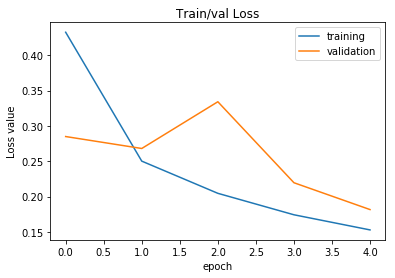

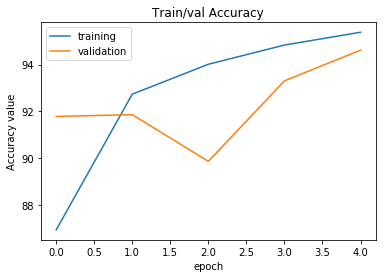

In [5]:
# train CNN
l_rates = [1*10**-i for i in range(1, 4)]
nb_epochs = 5
trainer = TrainHelper(nb_epochs)

# best parameters: (validation acc, learning rate)
best_parameters = (float("-INF"), None, None)
# keep a copy of the best trained network
best_model = None

loss_function = nn.CrossEntropyLoss()

for l_rate in l_rates:
    neural_net = PR_CNN()
    optimizer = torch.optim.SGD(neural_net.parameters(), l_rate)
    
    print(f'learning rate: {l_rate}')
    stats_training = trainer.fit(neural_net,
                            train_loader,
                            val_loader,
                            optimizer,
                            loss_function)
    
    if stats_training[3][-1] > best_parameters[0]:
        best_parameters = (stats_training[3][-1], l_rate, stats_training)
        best_model = deepcopy(neural_net)

best_acc, best_l_rate, best_stats = best_parameters
train_losses, val_losses, train_accuracies, val_accuracies = best_stats

print(f'\n\nBest parameters: {best_l_rate} learning_rate and validation accuracies: {best_acc:.2f}%')

plot_graph(nb_epochs, train_losses, val_losses, "Loss")
plot_graph(nb_epochs, train_accuracies, val_accuracies, "Accuracy")

In [6]:
# CNN - Test Dataset
loss_test, acc_test = trainer.validation(best_model, test_loader, loss_function)
print(f'Accuracy on the test dataset {acc_test:.2f}%')

Accuracy on the test dataset 94.73%


Now for the MLP

In [7]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, input_):
        #print(input_.shape)
        # input_ = input_.view(input_.size(0), -1)
        #print(input_.shape)
        return self.layers(input_)


In [8]:
input_dim = 28*28
hidden_dims = [i for i in range(10, 101, 10)]
output_dim = 10
l_rates = [1*10**-i for i in range(1, 4)]
nb_epochs = 15
trainer = TrainHelper(nb_epochs)

# best parameters: (validation acc, hidden dim, learning rate)
best_parameters = (float("-INF"), None, None, None)
# keep a copy of the best trained network
best_model = None

loss_function = nn.CrossEntropyLoss()

for hidden_dim, l_rate in product(hidden_dims, l_rates):
    neural_net = NeuralNetwork(input_dim, hidden_dim, output_dim)
    optimizer = torch.optim.SGD(neural_net.parameters(), l_rate)
    
    
    print(f'Hidden dim: {hidden_dim}, learning rate: {l_rate}')
    stats_training = trainer.fit(neural_net,
                                 train_loader,
                                 val_loader,
                                 optimizer,
                                 loss_function)
    
    if stats_training[3][-1] > best_parameters[0]:
        best_parameters = (stats_training[3][-1], hidden_dim, l_rate, stats_training)
        best_model = deepcopy(neural_net)

best_acc, best_hidden_dim, best_l_rate, best_stats = best_parameters
train_losses, val_losses, train_accuracies, val_accuracies = best_stats

print(f'\n\nBest parameters: {best_hidden_dim} hidden dim, \
{best_l_rate} learning_rate and validation accuracies: {best_acc:.2f}%')

plot_graph(nb_epochs, train_losses, val_losses, "Loss")
plot_graph(nb_epochs, train_accuracies, val_accuracies, "Accuracy")

Hidden dim: 10, learning rate: 0.1


RuntimeError: size mismatch, m1: [5376 x 28], m2: [784 x 10] at c:\a\w\1\s\tmp_conda_3.7_110206\conda\conda-bld\pytorch_1550401474361\work\aten\src\th\generic/THTensorMath.cpp:940

In [ ]:
loss_test, acc_test = trainer.validation(best_model, test_loader, loss_function)
print(f'Accuracy on the test dataset {acc_test:.2f}%')